# 1.0 Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import time
import warnings

# Tempo de processamento
time_agora = time.time()

###### 1.1 Loading dataset

In [2]:
# processed data
test = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\interim\\df_predict_request.pkl', 'rb'))
df = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\raw\\train.csv')

# columns
model_columns = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\interim\\model_columns.pkl', 'rb'))

# Feature selection
feature_selection = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\interim\\ranking_feature_selection.pkl', 'rb'))

# 2.0 Creating Database

In [3]:
cols = 'Response probability'.split()

test = test[cols]

test = test.rename(columns={'Response': 'response'})

test.sort_values('probability', ascending=False, inplace=True)

###### 2.1 Creating X_axis

In [4]:
total_base = test.shape[0]

test['prop_base'] = 1 / total_base

test['cum_prop_base'] = np.cumsum(test['prop_base'])

cols_to_del = ['prop_base']

###### 2.2 Cummulative Interesteds

In [5]:
total_interesteds = test['response'].sum()

test['cum_response'] = np.cumsum(test['response'])

test['cum_prop_response'] = test['cum_response'] / total_interesteds

###### 2.3 Baseline

In [6]:
test['baseline_model'] = 1 / total_base

test['baseline_model'] = np.cumsum(test['baseline_model'])

###### 2.4 Perfect Model

In [7]:
test.reset_index(drop=True, inplace=True)

test['perfect_model'] = 0

test.loc[range(0, total_interesteds, 1), 'perfect_model'] = 1

test['perfect_model'] = np.cumsum(test['perfect_model'])

test['perfect_model'] = test['perfect_model'] / total_interesteds

###### 2.5 Removing columns

In [8]:
cols_to_del.append('response')

test.drop(cols_to_del, axis=1, inplace=True)

# 3.0 Curva Lift

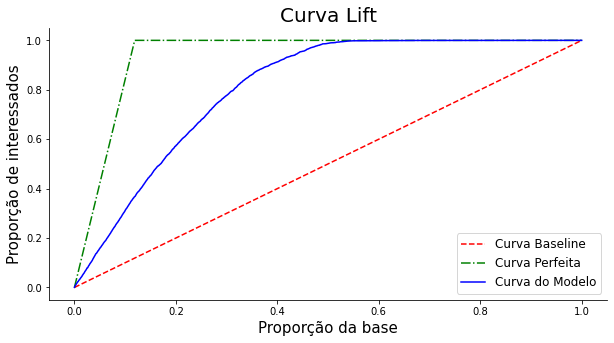

In [9]:
plt.figure(figsize=(10, 5))

sns.lineplot(data=test, x='cum_prop_base', y='baseline_model', linestyle='--', color='r', label='Curva Baseline')
sns.lineplot(data=test, x='cum_prop_base', y='perfect_model', color='g', linestyle='-.', label='Curva Perfeita')
sns.lineplot(data=test, x='cum_prop_base', y='cum_prop_response', color='b', label='Curva do Modelo')
plt.title('Curva Lift', fontsize=20)
plt.xlabel('Proporção da base', fontsize=15)
plt.ylabel('Proporção de interessados', fontsize=15)
plt.legend(prop={'size': 12}, loc='lower right')
sns.despine();

# 4.0 Business Answers

### 4.1 Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

###### Vehicle Damage e Previously Insured são os atributos mais importante da base: 
Clientes que já possuem seguro de automóvel dificilmente fecharão um contrato. Clientes que já sofreram danos e acionaram o sinistro no passado são mais propensos a fechar um contrato.

###### Region Code é importante: 
A região 28 contém 28% da base e tem uma média de Response de 18% de negócios fechados, bem acima da média geral.

###### Sales Channel é importante:
Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### Age:
A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.

### 4.2 Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [10]:
tam_base = df.shape[0]

ligações = 20000

proporção_ligações_base = ligações / tam_base
proporção_ligações_base
print(f'20.000 ligações significam {round(proporção_ligações_base*100,2)}% de toda a base')

cum_response_fatiado = int(test.loc[test['cum_prop_base'] < proporção_ligações_base, 'cum_response'].tail(1).values)
total_response = int(test['cum_response'].tail(1).values)
answer = cum_response_fatiado / total_response
print(f'Com 20.000 ligações o time de negócios irá cobrir por volta de {round(answer*100, 2)}% dos interessados')

20.000 ligações significam 5.25% de toda a base
Com 20.000 ligações o time de negócios irá cobrir por volta de 16.42% dos interessados


### 4.3 E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

In [11]:
tam_base = df.shape[0]

ligações = 40000

proporção_ligações_base = ligações / tam_base
proporção_ligações_base
print(f'40.000 ligações significam {round(proporção_ligações_base*100,2)}% de toda a base')

cum_response_fatiado = int(test.loc[test['cum_prop_base'] < proporção_ligações_base, 'cum_response'].tail(1).values)
total_response = int(test['cum_response'].tail(1).values)
answer = cum_response_fatiado / total_response
print(f'Com 20.000 ligações o time de negócios irá cobrir por volta de {round(answer*100, 2)}% dos interessados')

40.000 ligações significam 10.5% de toda a base
Com 20.000 ligações o time de negócios irá cobrir por volta de 32.72% dos interessados


### 4.4 Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

In [12]:
parametro = int(test.loc[test['cum_prop_response']<0.8].tail(1).index.values)
tam_base = df.shape[0]
tam_test = test.shape[0]
proporcional = tam_base / tam_test
answer = parametro * proporcional
answer_prop = answer / tam_base
print(f'Para cobrir 80% de todos os interessados o time de vendas precisará fazer {int(answer)} contatos,\num total de {round(answer_prop*100, 2)}% de toda base.')

Para cobrir 80% de todos os interessados o time de vendas precisará fazer 119629 contatos,
um total de 31.39% de toda base.


# Time

In [13]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-time_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 0 minutos
